In [1]:
##################################################
# imports
##################################################

# full libraries
import pandas
import sklearn
import numpy as np
import os
import warnings
import seaborn as sns

# methods
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from numpy import format_float_positional as sig

# check given file names and print
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/math482-2024-2025-1-hw-01/sample_submission.csv
/kaggle/input/math482-2024-2025-1-hw-01/train.csv
/kaggle/input/math482-2024-2025-1-hw-01/test.csv


# Predicting Blueberry Yields

In this notebook I will use the given data related to blueberries and try to train a model that predicts the yields of given fields.

In [2]:
##################################################
# Function definitions
##################################################
def r2_adjusted(n, p, r2):
    # n = number of data
    # p = number of features
    return 1 - (1 - r2)*((n-1)/(n-p-1))

# ignoring an error that does not matter yet.
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Data is perfectly clean, so we can go ahead and start.
# Read the data and shuffle the rows
data = pandas.read_csv("/kaggle/input/math482-2024-2025-1-hw-01/train.csv").sample(frac = 1) 
# Trimming left over data
data = data[["clonesize","honeybee","bumbles","andrena","osmia","MaxOfUpperTRange","MinOfUpperTRange",
             "AverageOfUpperTRange","MaxOfLowerTRange","MinOfLowerTRange","AverageOfLowerTRange","RainingDays",
             "AverageRainingDays","fruitset","fruitmass","seeds", "yield"]]

# Graphing and Preprocessing
First lets check the entire data variables just in case this gives us any ideas.

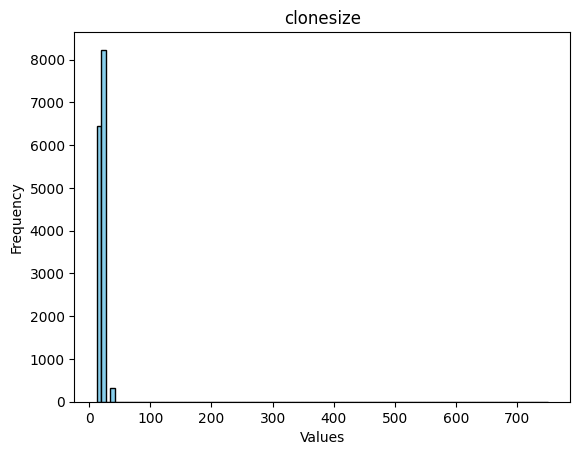

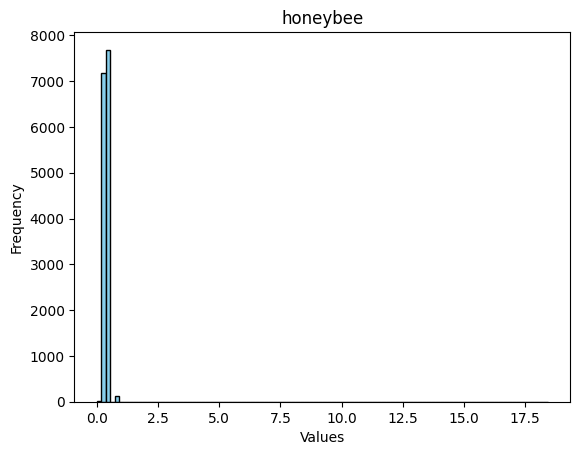

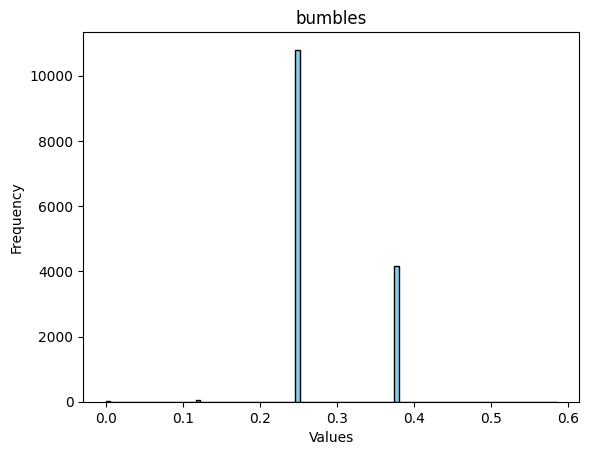

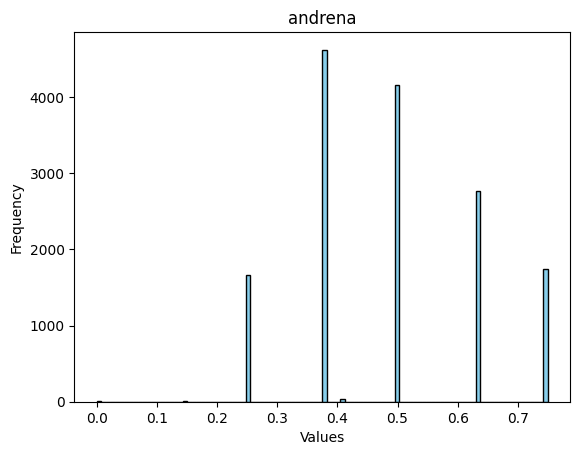

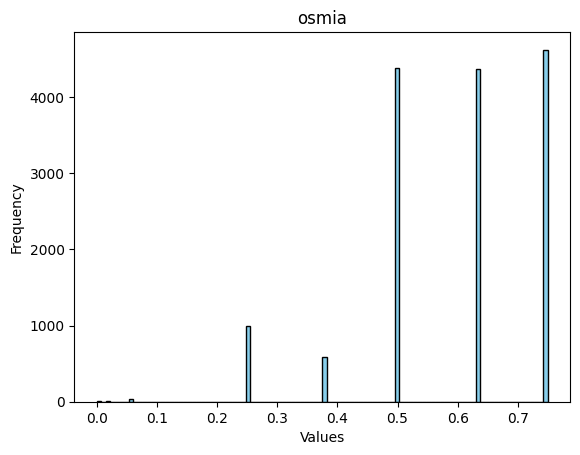

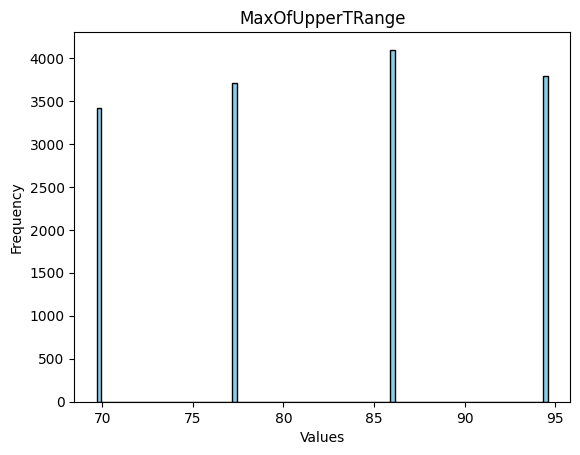

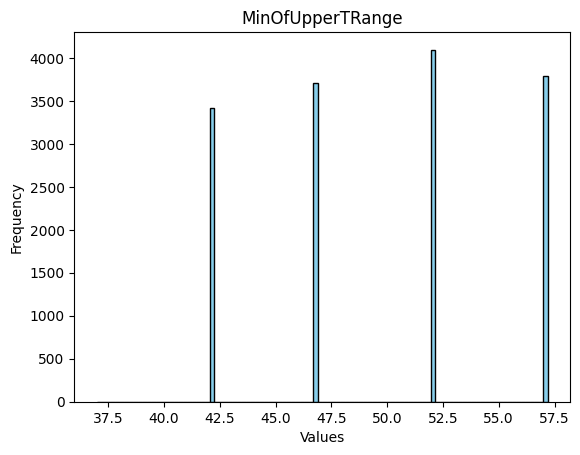

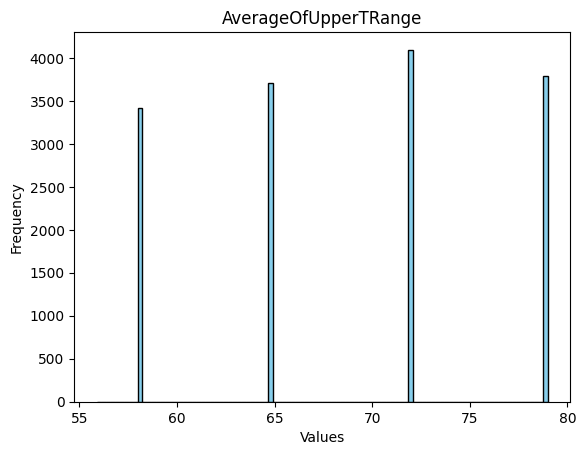

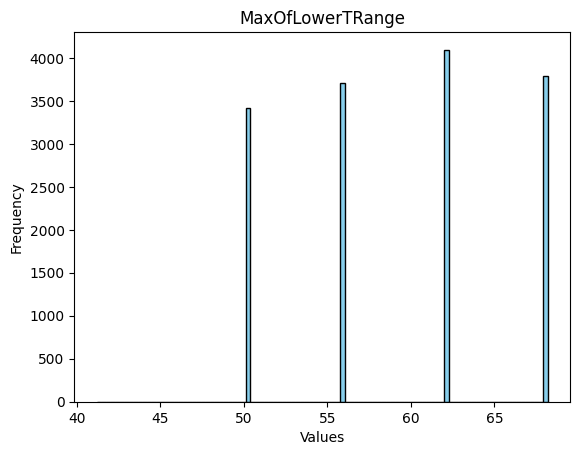

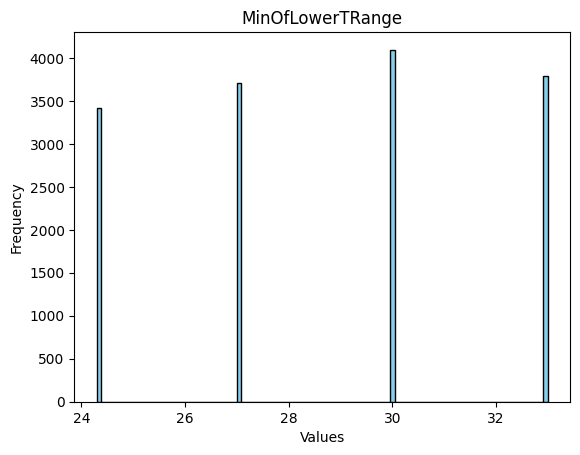

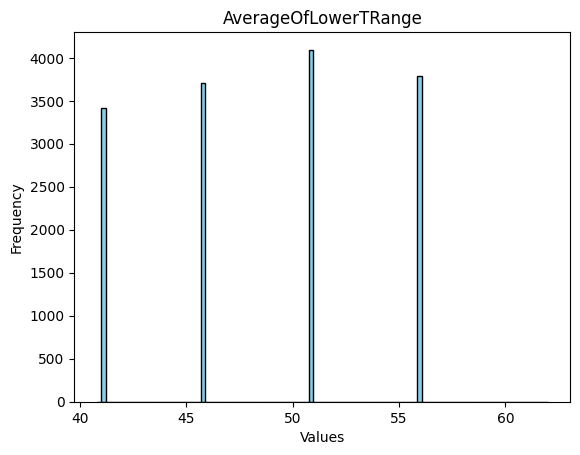

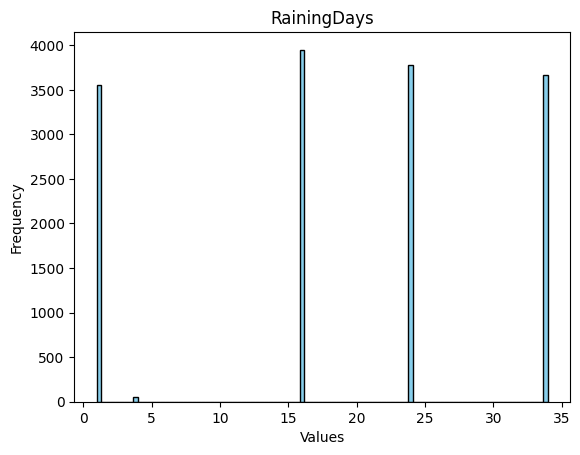

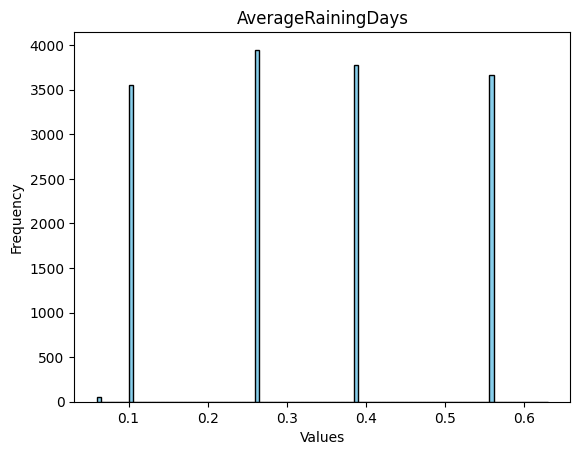

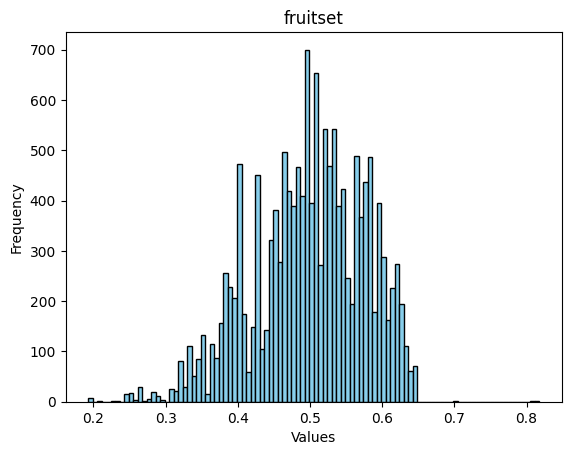

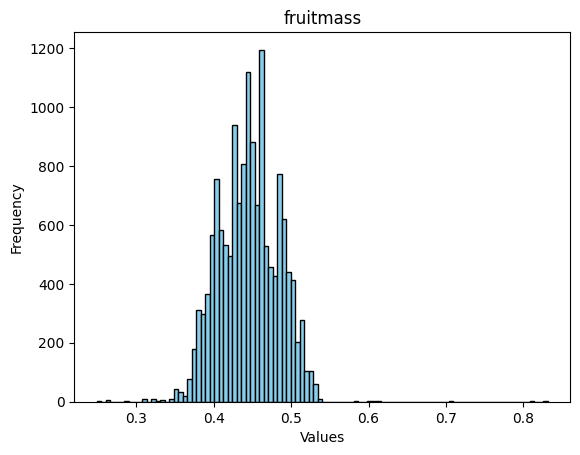

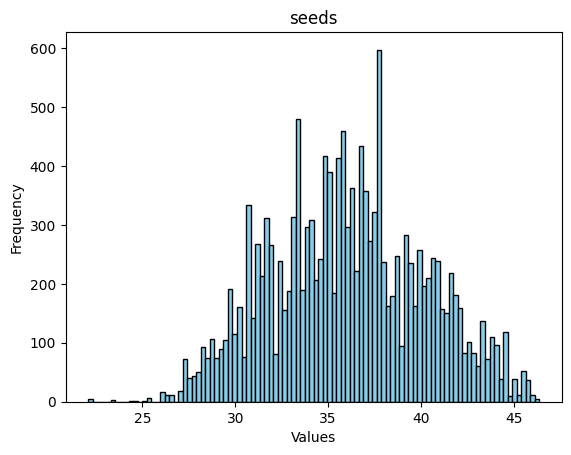

In [4]:
for i in range(0, len(data.columns) - 1):
    plt.hist(data.iloc[:,i], bins=100, color='skyblue', edgecolor='black')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title(data.columns[i])
    plt.show()

Distributions seems expected. Clonesize and honeybee data seem to have some erroneous outliers where Clonesize=750.633803 and honeybee=18.43. These will be removed from the data now. The rest of the outliers are not that far away from the normals and their numbers seem inconsequential. So I choose to keep them.

In [5]:
data = data.drop(data[data["clonesize"] == 750.633803].index)
data = data.drop(data[data["honeybee"] == 18.43].index)

Now check their histograms again.

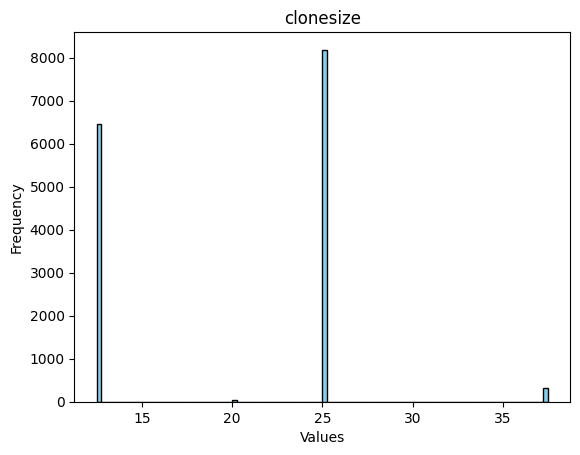

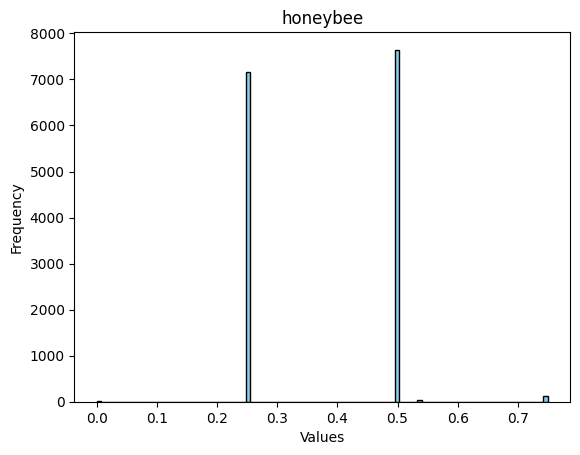

In [6]:
plt.hist(data["clonesize"], bins=100, color='skyblue', edgecolor='black')
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.title("clonesize")
plt.show()

plt.hist(data["honeybee"], bins=100, color='skyblue', edgecolor='black')
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.title("honeybee")
plt.show()

These look better. Now I will check the scatter plots of each variable with yield.

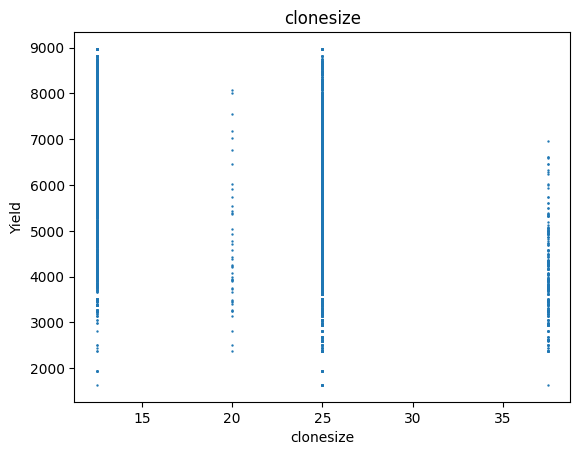

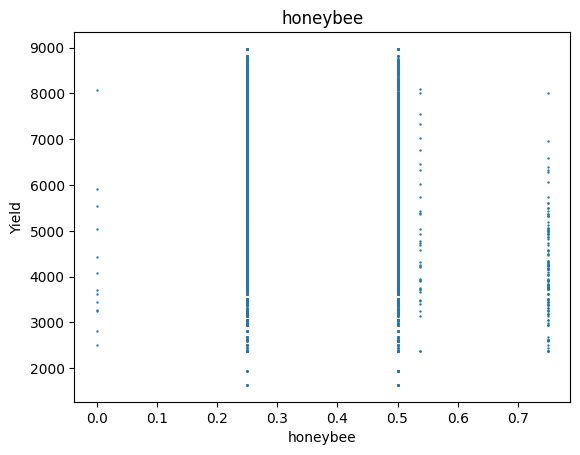

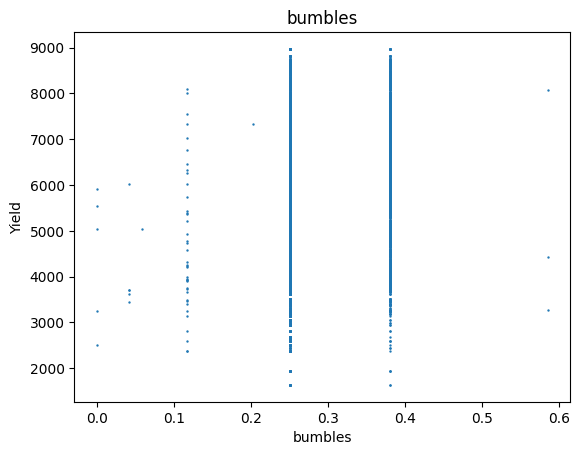

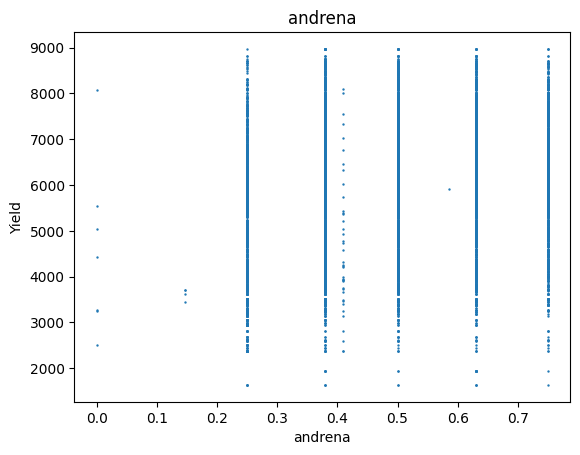

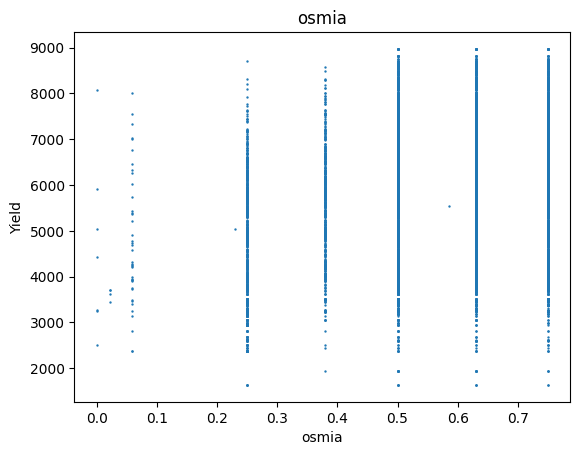

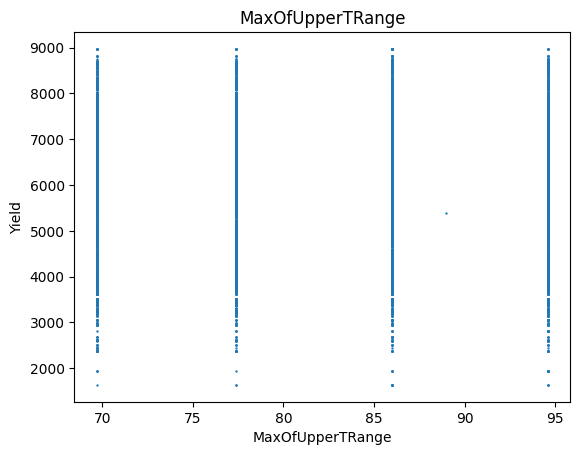

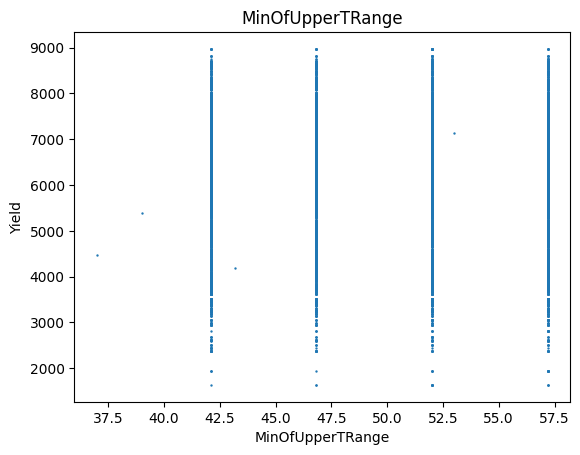

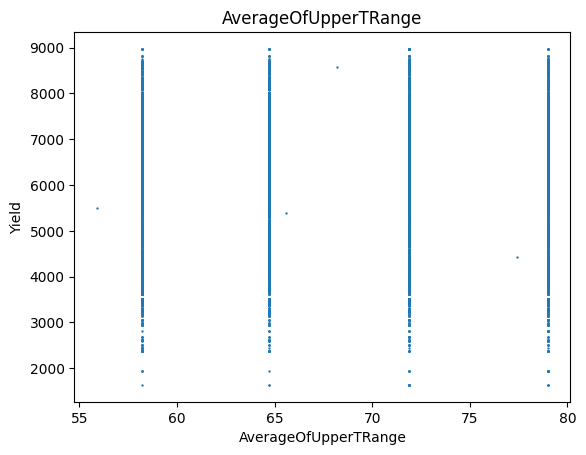

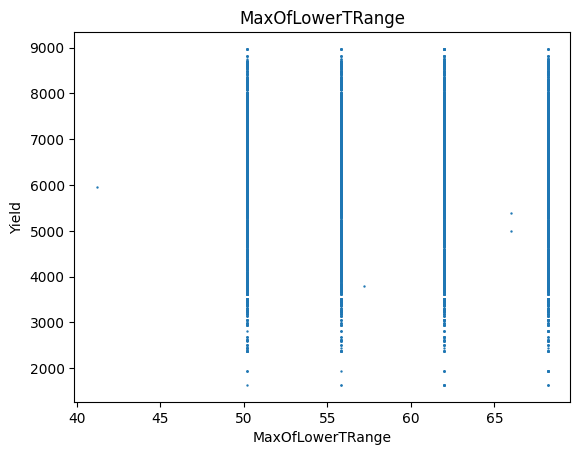

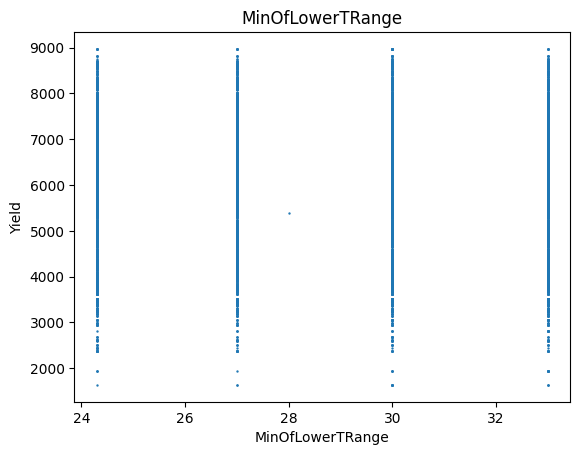

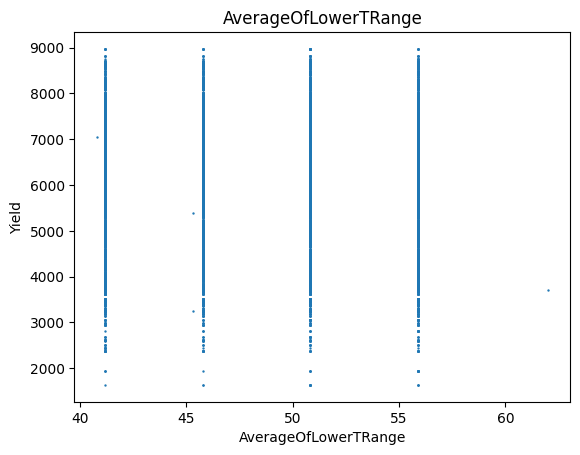

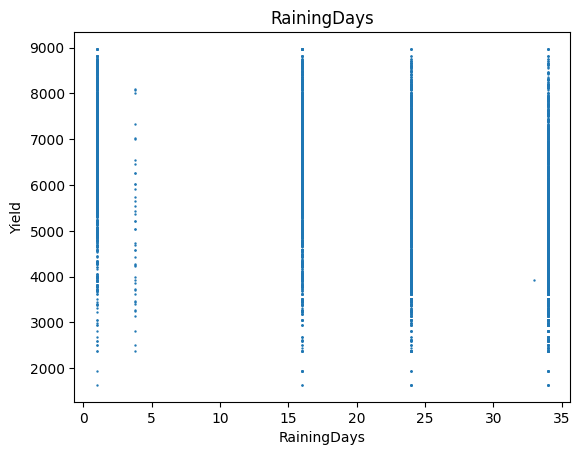

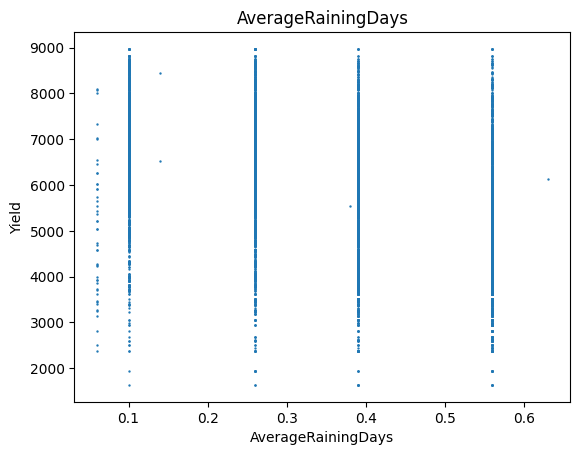

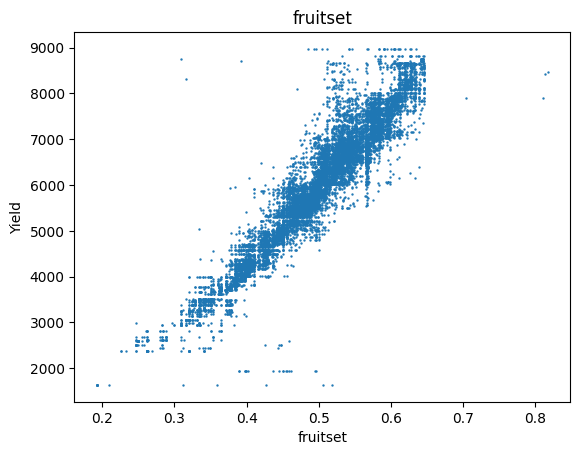

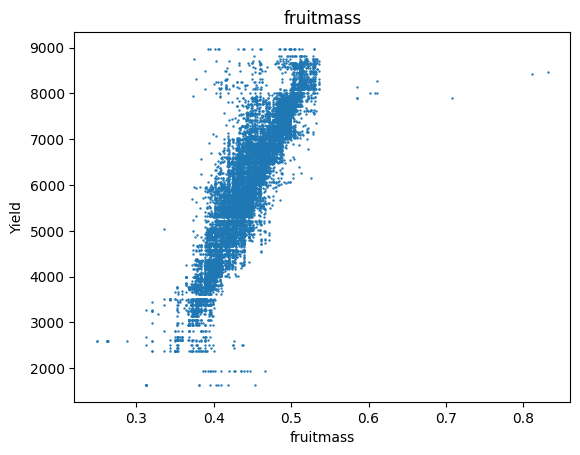

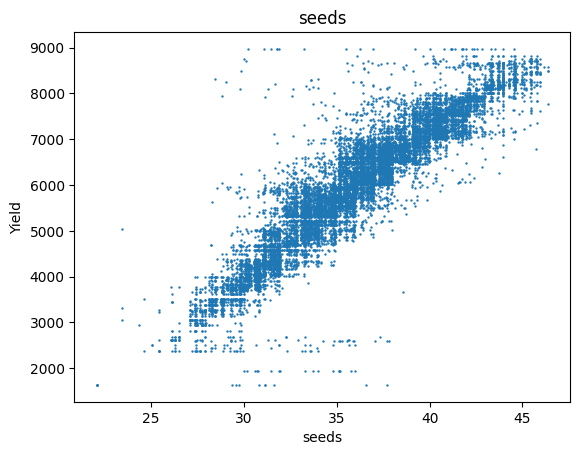

In [7]:
for i in range(0, len(data.columns) - 1):
    plt.scatter(data.iloc[:,i], data["yield"], s=0.5)
    plt.xlabel(data.columns[i])
    plt.ylabel("Yield")
    plt.title(data.columns[i])
    plt.show()

From these I understand that fruitset, fruitmass and seeds have a strong correlation with the yield. We will look deeper into this later.

Now checking boxplots of the variables against yield that are not these three to better understand them.

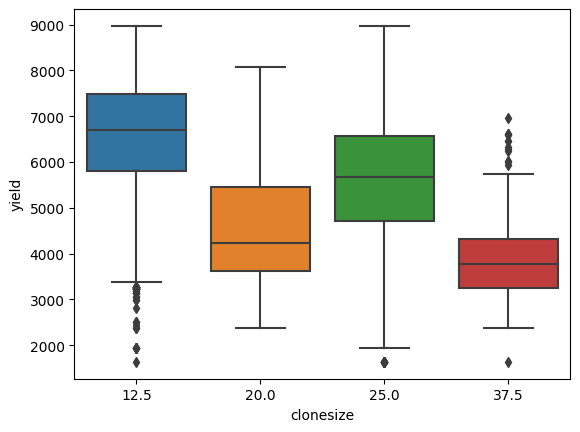

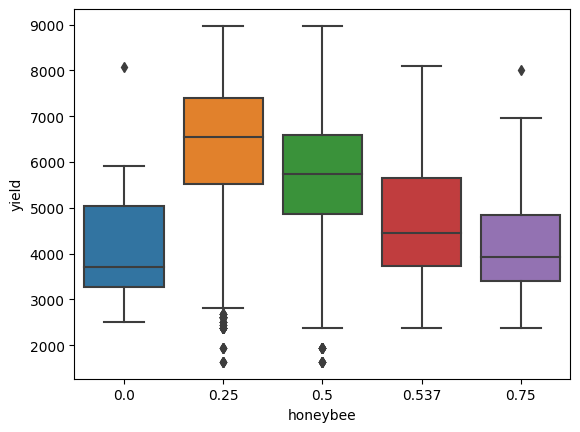

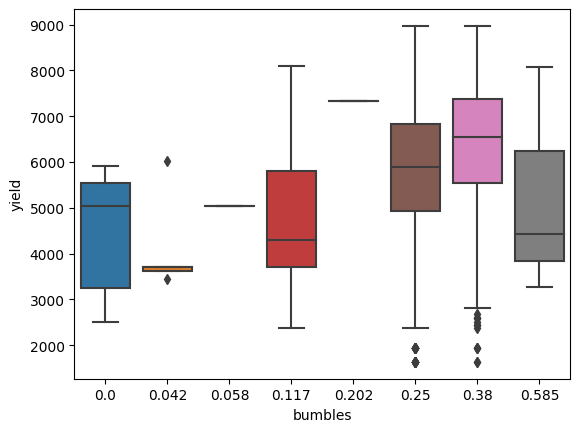

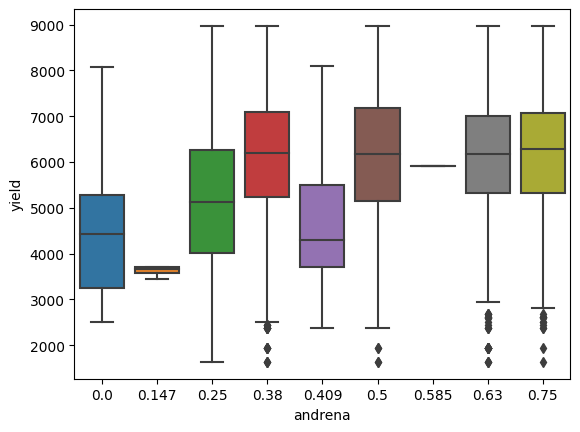

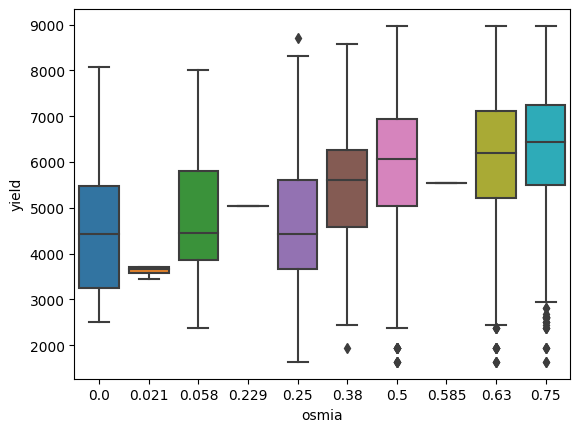

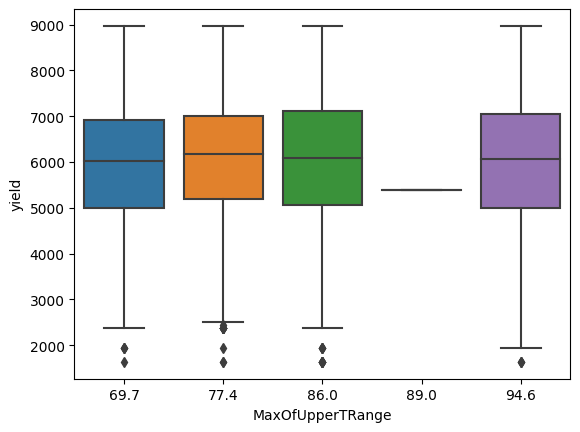

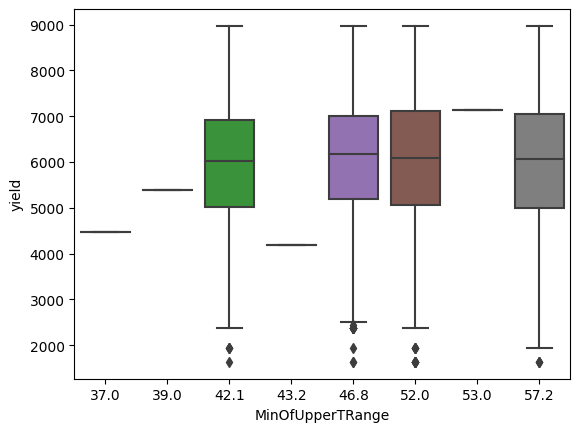

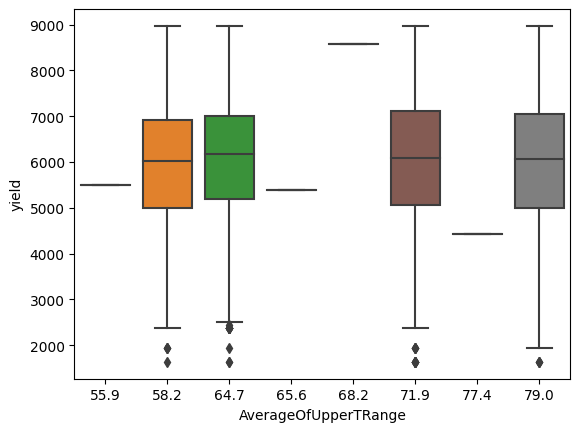

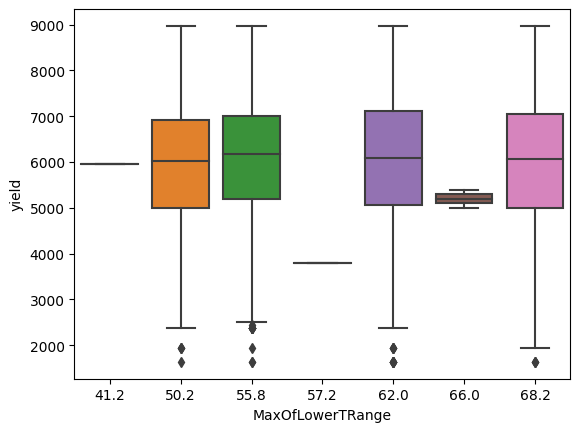

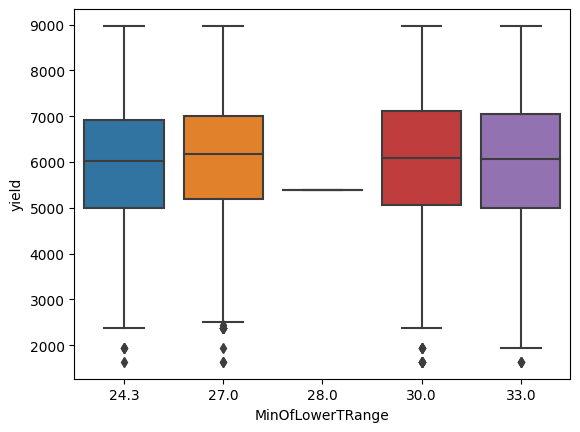

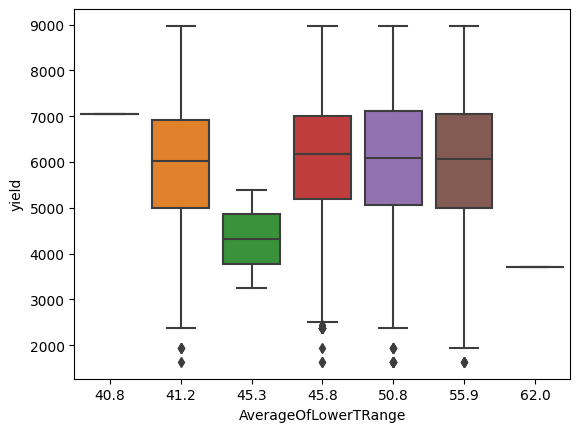

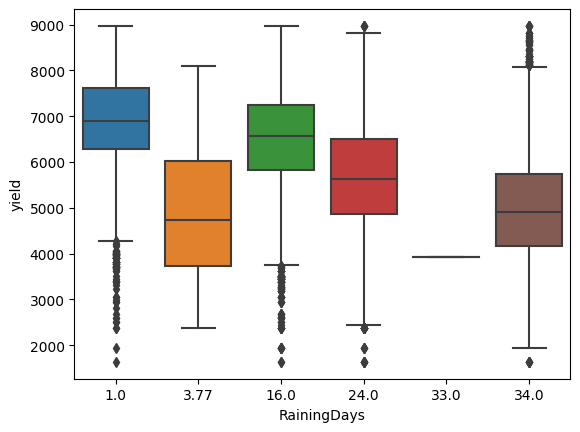

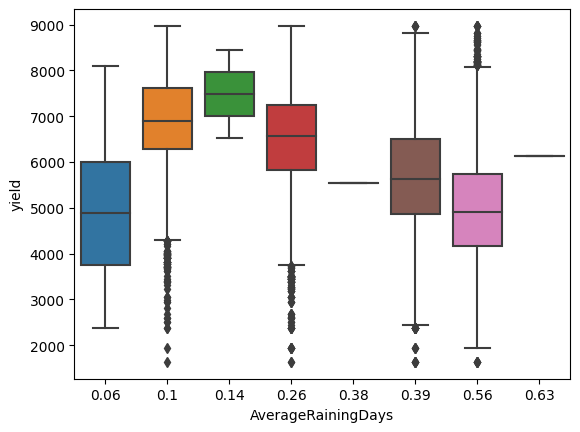

In [8]:
for i in range(0, len(data.columns) - 4):
    plt.figure()
    sns.boxplot(x=data.iloc[:,i],y=data["yield"])

Now we are ready to try some models. First see our data described.

In [9]:
data.describe()

,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
count,14996.000000,14996.000000,14996.000000,14996.000000,14996.000000,14996.000000,14996.000000,14996.000000,14996.000000,14996.000000,14996.000000,14996.000000,14996.000000,14996.000000,14996.000000,14996.000000,14996.000000
mean,19.883969,0.382379,0.285502,0.487844,0.592055,82.335783,49.772519,68.792865,59.345879,28.718405,48.667025,18.817395,0.327477,0.499399,0.445255,36.051277,5999.691514
std,6.666497,0.129643,0.059346,0.147493,0.145360,9.165288,5.556847,7.656349,6.623676,3.201525,5.402291,11.883689,0.167052,0.077066,0.038204,4.120430,1362.073438
min,12.500000,0.000000,0.000000,0.000000,0.000000,69.700000,37.000000,55.900000,41.200000,24.300000,40.800000,1.000000,0.060000,0.192732,0.249091,22.079199,1637.704020
25%,12.500000,0.250000,0.250000,0.380000,0.500000,77.400000,46.800000,64.700000,55.800000,27.000000,45.800000,16.000000,0.260000,0.450103,0.417915,33.221987,5046.457340
50%,25.000000,0.500000,0.250000,0.500000,0.630000,86.000000,52.000000,71.900000,62.000000,30.000000,50.800000,16.000000,0.260000,0.504761,0.445494,35.933802,6093.315270
75%,25.000000,0.500000,0.380000,0.630000,0.750000,94.600000,57.200000,79.000000,68.200000,33.000000,55.900000,24.000000,0.390000,0.561190,0.471650,39.091856,7016.893850
max,37.500000,0.750000,0.585000,0.750000,0.750000,94.600000,57.200000,79.000000,68.200000,33.000000,62.000000,34.000000,0.630000,0.817343,0.831514,46.369344,8969.401840


Here we divide the data into training and testing portions.

In [10]:
# Divide trimmed data 80 to 20 as training and testing data
training_data = data[:round(len(data)*0.8)]
testing_data = data[round(len(data)*0.8):]

# X is variables, y is yield.
X_train = training_data[["clonesize","honeybee","bumbles","andrena","osmia","MaxOfUpperTRange","MinOfUpperTRange",
                    "AverageOfUpperTRange","MaxOfLowerTRange","MinOfLowerTRange","AverageOfLowerTRange","RainingDays",
                   "AverageRainingDays","fruitset","fruitmass","seeds"]]
y_train = training_data[["yield"]]
X_test = testing_data[["clonesize","honeybee","bumbles","andrena","osmia","MaxOfUpperTRange","MinOfUpperTRange",
                   "AverageOfUpperTRange","MaxOfLowerTRange","MinOfLowerTRange","AverageOfLowerTRange","RainingDays",
                   "AverageRainingDays","fruitset","fruitmass","seeds"]]
y_test = testing_data[["yield"]]

Lets see out training data described now.

In [11]:
training_data.describe()

,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
count,11997.000000,11997.000000,11997.000000,11997.000000,11997.000000,11997.000000,11997.000000,11997.000000,11997.000000,11997.000000,11997.000000,11997.000000,11997.000000,11997.000000,11997.000000,11997.000000,11997.000000
mean,19.874135,0.381935,0.285541,0.487330,0.591575,82.327365,49.768117,68.786172,59.339452,28.715412,48.662157,18.761308,0.326725,0.499368,0.445195,36.048689,5999.298659
std,6.672397,0.129744,0.059301,0.147505,0.145617,9.170672,5.559577,7.661386,6.627763,3.203392,5.405753,11.896526,0.167091,0.077050,0.038080,4.122054,1360.929239
min,12.500000,0.000000,0.000000,0.000000,0.000000,69.700000,39.000000,55.900000,41.200000,24.300000,40.800000,1.000000,0.060000,0.192732,0.249091,22.079199,1637.704020
25%,12.500000,0.250000,0.250000,0.380000,0.500000,77.400000,46.800000,64.700000,55.800000,27.000000,45.800000,16.000000,0.260000,0.450103,0.417915,33.221987,5042.640340
50%,25.000000,0.500000,0.250000,0.500000,0.630000,86.000000,52.000000,71.900000,62.000000,30.000000,50.800000,16.000000,0.260000,0.504761,0.445484,35.933802,6079.085260
75%,25.000000,0.500000,0.380000,0.630000,0.750000,94.600000,57.200000,79.000000,68.200000,33.000000,55.900000,24.000000,0.390000,0.561297,0.471650,39.096884,7019.694380
max,37.500000,0.750000,0.585000,0.750000,0.750000,94.600000,57.200000,79.000000,68.200000,33.000000,62.000000,34.000000,0.560000,0.812803,0.810804,46.369344,8969.401840


Checking correlation of variables.

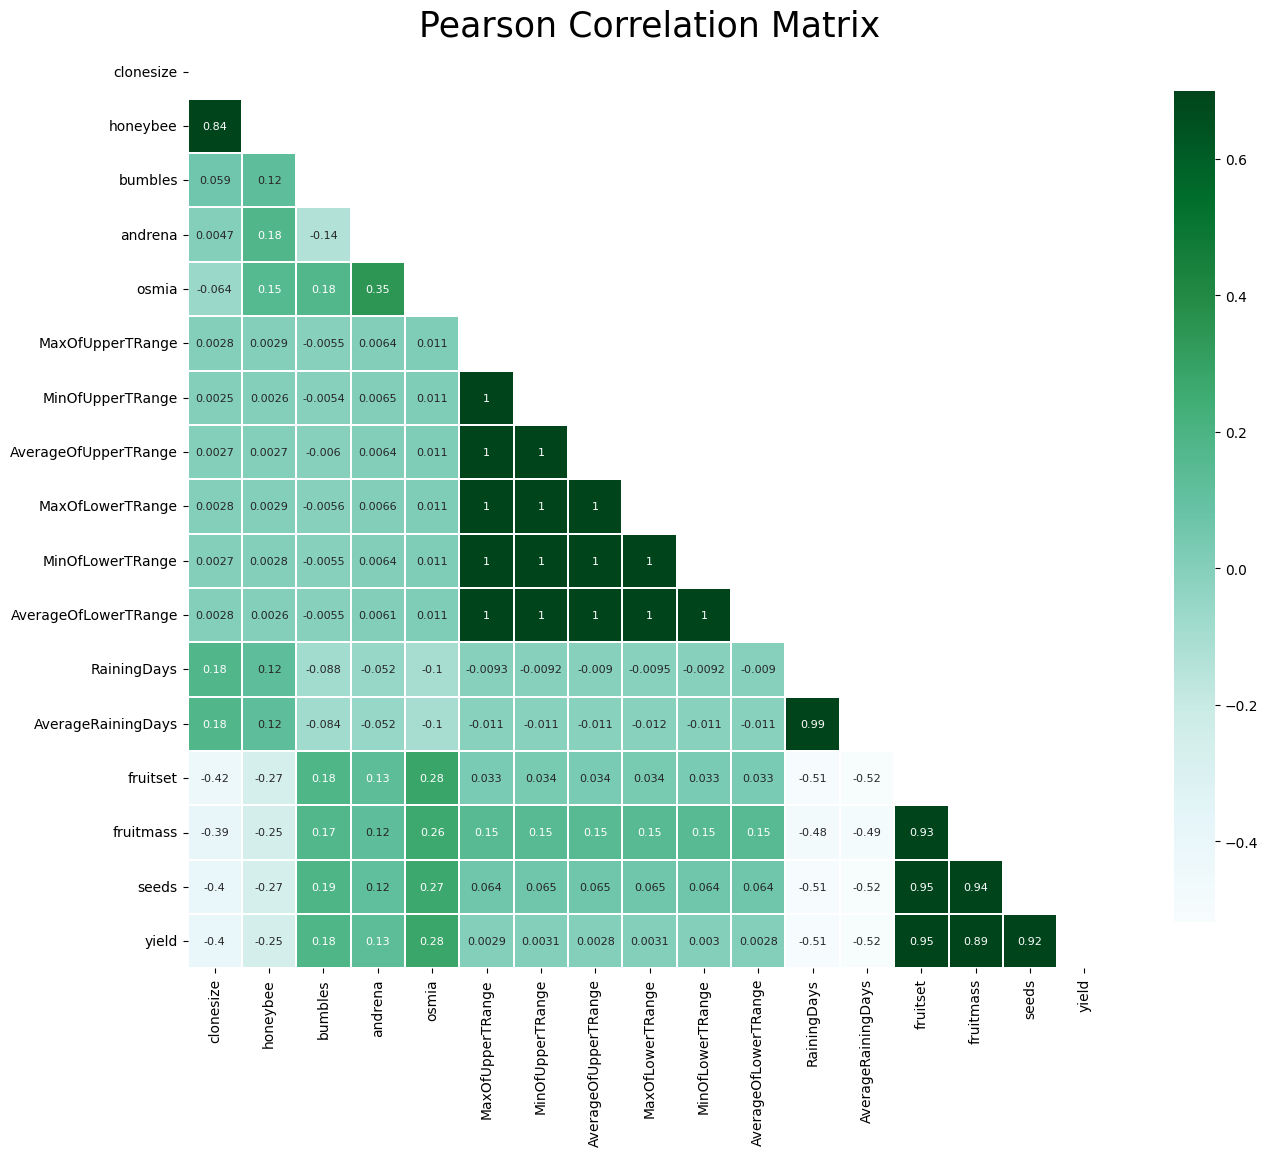

In [12]:
# This section of the code was copied from Burhan Y. Kiyakoglu
# https://www.kaggle.com/code/burhanykiyakoglu/predicting-house-prices/notebook

features = ["clonesize","honeybee","bumbles","andrena","osmia","MaxOfUpperTRange","MinOfUpperTRange",
            "AverageOfUpperTRange","MaxOfLowerTRange","MinOfLowerTRange","AverageOfLowerTRange","RainingDays",
            "AverageRainingDays","fruitset","fruitmass","seeds", "yield"]

mask = np.zeros_like(data[features].corr(), dtype=bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(data[features].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn", #"BuGn_r" to reverse 
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});

* From here we see that, expectedly, we should not use all the heat data at the same time in our model. Similar for the raining days. 
* I will assume seeds = seed amount per berry, fruitset = percentage of flowers that become fruit, fruitmass = average gram of berries. These seem to be very highly correlated, so I will try models omitting them.
* Honeybee and clonesize correlation shouldn't be an issue but we will still try models omitting one.

* I will first try three simple regression models using fruitset, fruitmass, seeds respectively.
* I opted to use the classic adjusted R to test my models.

# Simple Regression Fruitset 

Regression coefficient:


,fruitset
0,16765.415505


Residue scatterplot of model predicting testing data


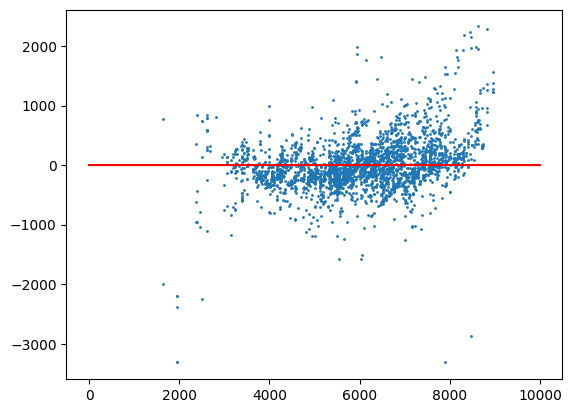

R adjusted score of testing is:  0.9047450098
Mean error of testing is 285.78 which is an error margin of 0.04762


In [13]:
##################################################
# Training and Testing the Models
##################################################

# Simple Regression Fruitset 
# Sklearn demands single feature arrays to be reshaped as follows
my_model = linear_model.LinearRegression().fit(np.array(X_train["fruitset"]).reshape(-1, 1), y_train)
# my_model name will be used for every model for ease of use.

# Check regression values for each variable
my_model_coefficients = pandas.DataFrame(my_model.coef_, columns=[["fruitset"]])

print("Regression coefficient:")
# notebook specific print
display(my_model_coefficients)

# Residues
residues_train = y_train - my_model.predict(np.array(X_train["fruitset"]).reshape(-1, 1))
residues_test = y_test - my_model.predict(np.array(X_test["fruitset"]).reshape(-1, 1)) # Calculating the residues

my_line = np.linspace(0, 0, 10000) # Creating a line from (0,0) to (0,10000)

print("Residue scatterplot of model predicting testing data")
plt.scatter(y_test["yield"], residues_test, s=1) # Drawing residue scatterplot of model predicting testing data
plt.plot(my_line, c="r") # Drawing the line
plt.show() # Show and clear plot data

# adjusted r2
r2_test = r2_score(y_test, my_model.predict(np.array(X_test["fruitset"]).reshape(-1, 1)))
r2_test_adjusted = r2_adjusted(len(y_test), 1, r2_test)
print("R adjusted score of testing is: ", sig(r2_test_adjusted, precision=10, unique=False, fractional=True, trim="k"))

# mean error
mean_error = mean_absolute_error(y_test, my_model.predict(np.array(X_test["fruitset"]).reshape(-1, 1)))
print("Mean error of testing is",
      sig(mean_error, precision=2, unique=False, fractional=True, trim="k"),
      "which is an error margin of",
      sig(mean_error / y_test["yield"].mean(), precision=5, unique=False, fractional=True, trim="k"))

# Simple Regression Fruitmass

Regression coefficient:


,fruitmass
0,31674.197388


Residue scatterplot of model predicting testing data


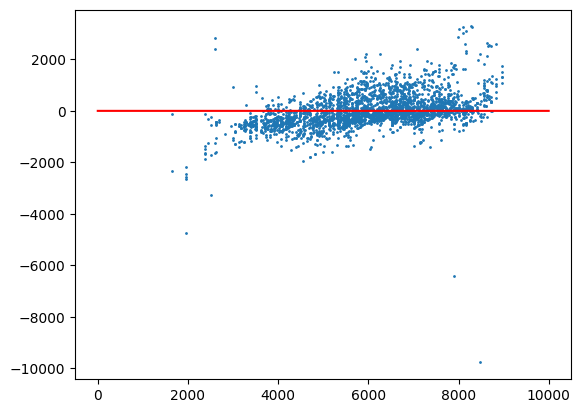

R adjusted score of testing is:  0.7762154691
Mean error of testing is 444.65 which is an error margin of 0.07409


In [14]:
# Simple Regression Fruitmass
# Sklearn demands single feature arrays to be reshaped as follows
my_model = linear_model.LinearRegression().fit(np.array(X_train["fruitmass"]).reshape(-1, 1), y_train)
# my_model name will be used for every model for ease of use.

# Check regression values for each variable
my_model_coefficients = pandas.DataFrame(my_model.coef_, columns=[["fruitmass"]])

print("Regression coefficient:")
# notebook specific print
display(my_model_coefficients)

# Residues
residues_train = y_train - my_model.predict(np.array(X_train["fruitmass"]).reshape(-1, 1))
residues_test = y_test - my_model.predict(np.array(X_test["fruitmass"]).reshape(-1, 1)) # Calculating the residues

my_line = np.linspace(0, 0, 10000) # Creating a line from (0,0) to (0,10000)

print("Residue scatterplot of model predicting testing data")
plt.scatter(y_test["yield"], residues_test, s=1) # Drawing residue scatterplot of model predicting testing data
plt.plot(my_line, c="r") # Drawing the line
plt.show() # Show and clear plot data

# adjusted r2
r2_test = r2_score(y_test, my_model.predict(np.array(X_test["fruitmass"]).reshape(-1, 1)))
r2_test_adjusted = r2_adjusted(len(y_test), 1, r2_test)
print("R adjusted score of testing is: ", sig(r2_test_adjusted, precision=10, unique=False, fractional=True, trim="k"))

# mean error
mean_error = mean_absolute_error(y_test, my_model.predict(np.array(X_test["fruitmass"]).reshape(-1, 1)))
print("Mean error of testing is",
      sig(mean_error, precision=2, unique=False, fractional=True, trim="k"),
      "which is an error margin of",
      sig(mean_error / y_test["yield"].mean(), precision=5, unique=False, fractional=True, trim="k"))

# Simple Regression Seeds

Regression coefficient:


,seeds
0,304.148616


Residue scatterplot of model predicting testing data


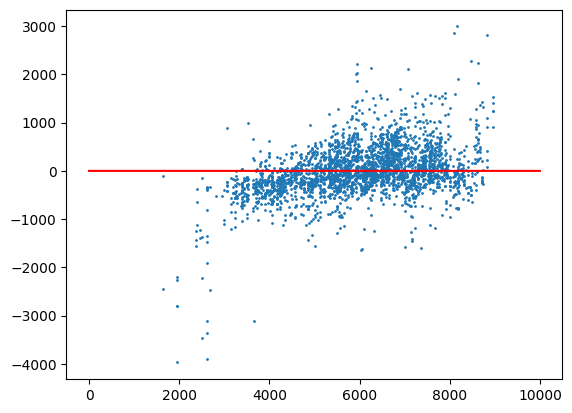

R adjusted score of testing is:  0.8614364032
Mean error of testing is 353.81 which is an error margin of 0.05896


In [15]:
# Simple Regression Seeds
# Sklearn demands single feature arrays to be reshaped as follows
my_model = linear_model.LinearRegression().fit(np.array(X_train["seeds"]).reshape(-1, 1), y_train)
# my_model name will be used for every model for ease of use.

# Check regression values for each variable
my_model_coefficients = pandas.DataFrame(my_model.coef_, columns=[["seeds"]])

print("Regression coefficient:")
# notebook specific print
display(my_model_coefficients)

# Residues
residues_train = y_train - my_model.predict(np.array(X_train["seeds"]).reshape(-1, 1))
residues_test = y_test - my_model.predict(np.array(X_test["seeds"]).reshape(-1, 1)) # Calculating the residues

my_line = np.linspace(0, 0, 10000) # Creating a line from (0,0) to (0,10000)

print("Residue scatterplot of model predicting testing data")
plt.scatter(y_test["yield"], residues_test, s=1) # Drawing residue scatterplot of model predicting testing data
plt.plot(my_line, c="r") # Drawing the line
plt.show() # Show and clear plot data

# adjusted r2
r2_test = r2_score(y_test, my_model.predict(np.array(X_test["seeds"]).reshape(-1, 1)))
r2_test_adjusted = r2_adjusted(len(y_test), 1, r2_test)
print("R adjusted score of testing is: ", sig(r2_test_adjusted, precision=10, unique=False, fractional=True, trim="k"))

# mean error
mean_error = mean_absolute_error(y_test, my_model.predict(np.array(X_test["seeds"]).reshape(-1, 1)))
print("Mean error of testing is",
      sig(mean_error, precision=2, unique=False, fractional=True, trim="k"),
      "which is an error margin of",
      sig(mean_error / y_test["yield"].mean(), precision=5, unique=False, fractional=True, trim="k"))

Now I will switch to multiple regressions. I will first try a model that uses all the features. Than I will try with only one heat value, AverageOfUpperTrange, and only one rain value, RainingDays while keeping the rest of the features.

# Multiple Regression All Values

Regression coefficients:


,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds
0,-1.337254,55.029606,102.713257,18.356838,82.532679,2316.248916,2063.912289,-14.116282,-57.091924,-10062.66864,-5.528599,2.321419,-371.806295,13460.158759,-2975.880794,86.456931


Residue scatterplot of model predicting testing data


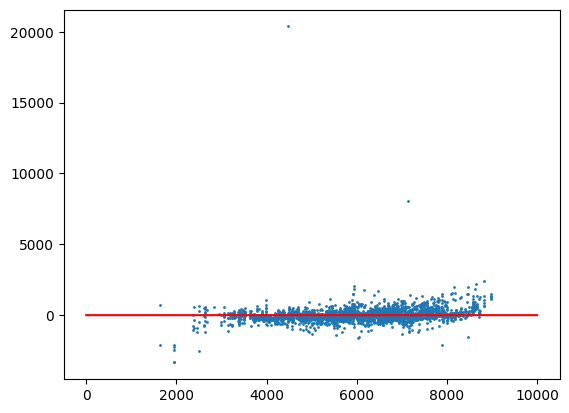

R adjusted score of testing is:  0.8284335753
Mean error of testing is 281.09 which is an error margin of 0.04684


In [16]:
# Multiple Regression All Values
my_model = linear_model.LinearRegression().fit(X_train, y_train)
# my_model name will be used for every model for ease of use.

# Check regression values for each variable
my_model_coefficients = pandas.DataFrame(my_model.coef_, columns=[["clonesize","honeybee","bumbles","andrena","osmia",
                                                                   "MaxOfUpperTRange","MinOfUpperTRange",
                                                                   "AverageOfUpperTRange","MaxOfLowerTRange",
                                                                   "MinOfLowerTRange","AverageOfLowerTRange",
                                                                   "RainingDays","AverageRainingDays","fruitset",
                                                                   "fruitmass","seeds"]])
# notebook specific print
print("Regression coefficients:")
display(my_model_coefficients)

# Residues
residues_train = y_train - my_model.predict(X_train)
residues_test = y_test - my_model.predict(X_test) # Calculating the residues

my_line = np.linspace(0, 0, 10000) # Creating a line from (0,0) to (0,10000)

print("Residue scatterplot of model predicting testing data")
plt.scatter(y_test["yield"], residues_test, s=1) # Drawing residue scatterplot of model predicting testing data
plt.plot(my_line, c="r") # Drawing the line
plt.show() # Show and clear plot data

# adjusted r2
r2_test = r2_score(y_test, my_model.predict(X_test))
r2_test_adjusted = r2_adjusted(len(y_test), len(X_test.columns), r2_test)
print("R adjusted score of testing is: ", sig(r2_test_adjusted, precision=10, unique=False, fractional=True, trim="k"))

# mean error
mean_error = mean_absolute_error(y_test, my_model.predict(X_test))
print("Mean error of testing is",
      sig(mean_error, precision=2, unique=False, fractional=True, trim="k"),
      "which is an error margin of",
      sig(mean_error / y_test["yield"].mean(), precision=5, unique=False, fractional=True, trim="k"))

# Multiple Regression Adjusted Features 1
* features = ["clonesize","honeybee","bumbles","andrena","osmia","AverageOfUpperTRange","RainingDays","fruitset","fruitmass","seeds"]

Regression coefficients:


,clonesize,honeybee,bumbles,andrena,osmia,AverageOfUpperTRange,RainingDays,fruitset,fruitmass,seeds
0,-1.485775,58.300816,107.256475,16.914831,87.212801,-4.593784,-2.881739,13624.300079,-3417.631658,86.951753


Residue scatterplot of model predicting testing data


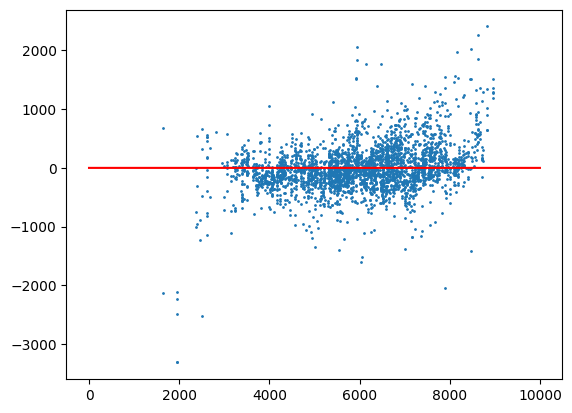

R adjusted score of testing is:  0.9140153726
Mean error of testing is 273.10 which is an error margin of 0.04551


In [17]:
# Multiple Regression Adjusted Features 1
# Selecting the feaatures to use
features = ["clonesize","honeybee","bumbles","andrena","osmia","AverageOfUpperTRange","RainingDays","fruitset","fruitmass","seeds"]

my_model = linear_model.LinearRegression().fit(X_train[features], y_train)
# my_model name will be used for every model for ease of use.

# Check regression values for each variable
my_model_coefficients = pandas.DataFrame(my_model.coef_, columns=[features])

# notebook specific print
print("Regression coefficients:")
display(my_model_coefficients)

# Residues
residues_train = y_train - my_model.predict(X_train[features])
residues_test = y_test - my_model.predict(X_test[features]) # Calculating the residues

my_line = np.linspace(0, 0, 10000) # Creating a line from (0,0) to (0,10000)

print("Residue scatterplot of model predicting testing data")
plt.scatter(y_test["yield"], residues_test, s=1) # Drawing residue scatterplot of model predicting testing data
plt.plot(my_line, c="r") # Drawing the line
plt.show() # Show and clear plot data

# adjusted r2
r2_test = r2_score(y_test, my_model.predict(X_test[features]))
r2_test_adjusted = r2_adjusted(len(y_test), len(X_test[features].columns), r2_test)
print("R adjusted score of testing is: ", sig(r2_test_adjusted, precision=10, unique=False, fractional=True, trim="k"))

# mean error
mean_error = mean_absolute_error(y_test, my_model.predict(X_test[features]))
print("Mean error of testing is",
      sig(mean_error, precision=2, unique=False, fractional=True, trim="k"),
      "which is an error margin of",
      sig(mean_error / y_test["yield"].mean(), precision=5, unique=False, fractional=True, trim="k"))

# Multiple Regression Adjusted Features 2
* features = ["clonesize","honeybee","bumbles","andrena","osmia","AverageOfUpperTRange","RainingDays","fruitset"]

Regression coefficients:


,clonesize,honeybee,bumbles,andrena,osmia,AverageOfUpperTRange,RainingDays,fruitset
0,-0.415988,-41.948203,204.395051,19.546082,101.851211,-5.014319,-3.825132,16357.232135


Residue scatterplot of model predicting testing data


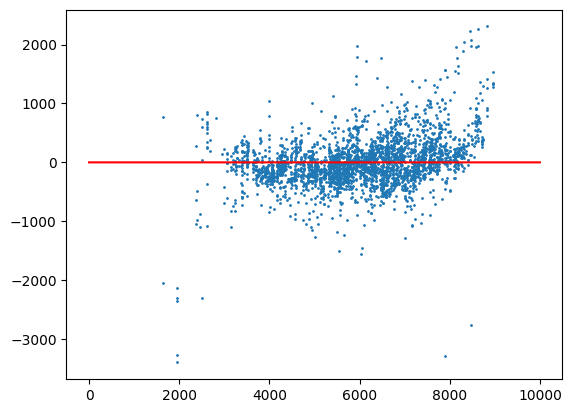

R adjusted score of testing is:  0.9063400836
Mean error of testing is 283.58 which is an error margin of 0.04725


In [18]:
# Multiple Regression Adjusted Features 2
# Selecting the feaatures to use
features = ["clonesize","honeybee","bumbles","andrena","osmia","AverageOfUpperTRange","RainingDays","fruitset"]

my_model = linear_model.LinearRegression().fit(X_train[features], y_train)
# my_model name will be used for every model for ease of use.

# Check regression values for each variable
my_model_coefficients = pandas.DataFrame(my_model.coef_, columns=[features])

# notebook specific print
print("Regression coefficients:")
display(my_model_coefficients)

# Residues
residues_train = y_train - my_model.predict(X_train[features])
residues_test = y_test - my_model.predict(X_test[features]) # Calculating the residues

my_line = np.linspace(0, 0, 10000) # Creating a line from (0,0) to (0,10000)

print("Residue scatterplot of model predicting testing data")
plt.scatter(y_test["yield"], residues_test, s=1) # Drawing residue scatterplot of model predicting testing data
plt.plot(my_line, c="r") # Drawing the line
plt.show() # Show and clear plot data

# adjusted r2
r2_test = r2_score(y_test, my_model.predict(X_test[features]))
r2_test_adjusted = r2_adjusted(len(y_test), len(X_test[features].columns), r2_test)
print("R adjusted score of testing is: ", sig(r2_test_adjusted, precision=10, unique=False, fractional=True, trim="k"))

# mean error
mean_error = mean_absolute_error(y_test, my_model.predict(X_test[features]))
print("Mean error of testing is",
      sig(mean_error, precision=2, unique=False, fractional=True, trim="k"),
      "which is an error margin of",
      sig(mean_error / y_test["yield"].mean(), precision=5, unique=False, fractional=True, trim="k"))

# Multiple Regression Adjusted Features 3
* features = ["clonesize","bumbles","andrena","osmia","AverageOfUpperTRange","RainingDays","fruitset","fruitmass","seeds"]

Regression coefficients:


,clonesize,bumbles,andrena,osmia,AverageOfUpperTRange,RainingDays,fruitset,fruitmass,seeds
0,-0.51582,115.15247,23.350079,95.123919,-4.589965,-2.877322,13639.364235,-3423.412335,86.761856


Residue scatterplot of model predicting testing data


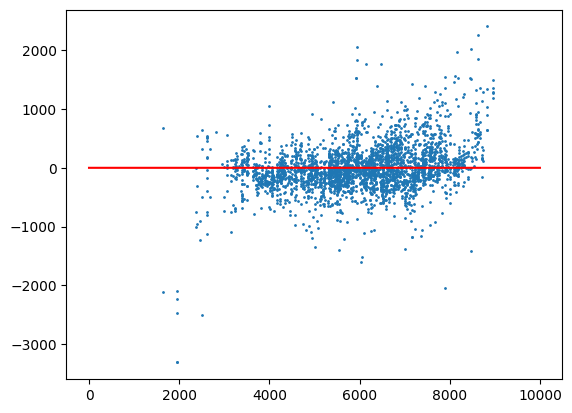

R adjusted score of testing is:  0.9140460971
Mean error of testing is 273.04 which is an error margin of 0.04550


In [19]:
# Multiple Regression Adjusted Features 3
# Selecting the feaatures to use
features = ["clonesize","bumbles","andrena","osmia","AverageOfUpperTRange","RainingDays","fruitset","fruitmass","seeds"]

my_model = linear_model.LinearRegression().fit(X_train[features], y_train)
# my_model name will be used for every model for ease of use.

# Check regression values for each variable
my_model_coefficients = pandas.DataFrame(my_model.coef_, columns=[features])

# notebook specific print
print("Regression coefficients:")
display(my_model_coefficients)

# Residues
residues_train = y_train - my_model.predict(X_train[features])
residues_test = y_test - my_model.predict(X_test[features]) # Calculating the residues

my_line = np.linspace(0, 0, 10000) # Creating a line from (0,0) to (0,10000)

print("Residue scatterplot of model predicting testing data")
plt.scatter(y_test["yield"], residues_test, s=1) # Drawing residue scatterplot of model predicting testing data
plt.plot(my_line, c="r") # Drawing the line
plt.show() # Show and clear plot data

# adjusted r2
r2_test = r2_score(y_test, my_model.predict(X_test[features]))
r2_test_adjusted = r2_adjusted(len(y_test), len(X_test[features].columns), r2_test)
print("R adjusted score of testing is: ", sig(r2_test_adjusted, precision=10, unique=False, fractional=True, trim="k"))

# mean error
mean_error = mean_absolute_error(y_test, my_model.predict(X_test[features]))
print("Mean error of testing is",
      sig(mean_error, precision=2, unique=False, fractional=True, trim="k"),
      "which is an error margin of",
      sig(mean_error / y_test["yield"].mean(), precision=5, unique=False, fractional=True, trim="k"))

# Multiple Regression Adjusted Features 4
* features = ["clonesize","bumbles","andrena","osmia","AverageOfUpperTRange","RainingDays","fruitset"]

Regression coefficients:


,clonesize,bumbles,andrena,osmia,AverageOfUpperTRange,RainingDays,fruitset
0,-1.114752,198.878534,14.895121,96.156453,-5.01207,-3.830254,16355.031984


Residue scatterplot of model predicting testing data


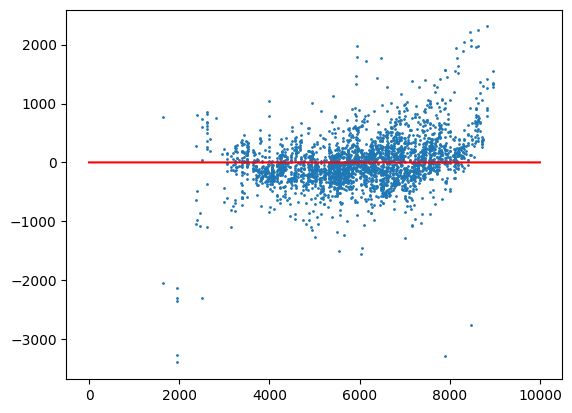

R adjusted score of testing is:  0.9063641810
Mean error of testing is 283.62 which is an error margin of 0.04726


In [20]:
# Multiple Regression Adjusted Features 4
# Selecting the feaatures to use
features = ["clonesize","bumbles","andrena","osmia","AverageOfUpperTRange","RainingDays","fruitset"]

my_model = linear_model.LinearRegression().fit(X_train[features], y_train)
# my_model name will be used for every model for ease of use.

# Check regression values for each variable
my_model_coefficients = pandas.DataFrame(my_model.coef_, columns=[features])

# notebook specific print
print("Regression coefficients:")
display(my_model_coefficients)

# Residues
residues_train = y_train - my_model.predict(X_train[features])
residues_test = y_test - my_model.predict(X_test[features]) # Calculating the residues

my_line = np.linspace(0, 0, 10000) # Creating a line from (0,0) to (0,10000)

print("Residue scatterplot of model predicting testing data")
plt.scatter(y_test["yield"], residues_test, s=1) # Drawing residue scatterplot of model predicting testing data
plt.plot(my_line, c="r") # Drawing the line
plt.show() # Show and clear plot data

# adjusted r2
r2_test = r2_score(y_test, my_model.predict(X_test[features]))
r2_test_adjusted = r2_adjusted(len(y_test), len(X_test[features].columns), r2_test)
print("R adjusted score of testing is: ", sig(r2_test_adjusted, precision=10, unique=False, fractional=True, trim="k"))

# mean error
mean_error = mean_absolute_error(y_test, my_model.predict(X_test[features]))
print("Mean error of testing is",
      sig(mean_error, precision=2, unique=False, fractional=True, trim="k"),
      "which is an error margin of",
      sig(mean_error / y_test["yield"].mean(), precision=5, unique=False, fractional=True, trim="k"))

# Final Model
I see that more adjusting does not increase model quality. Thus I settle for Multiple Regression Adjusted Features 1 with
* features = ["clonesize","honeybee","bumbles","andrena","osmia","AverageOfUpperTRange","RainingDays","fruitset","fruitmass","seeds"]

In [21]:
##################################################
# Predicting requested values
##################################################
# Multiple Regression Adjusted Features 1
features = ["clonesize","honeybee","bumbles","andrena","osmia","AverageOfUpperTRange","RainingDays","fruitset","fruitmass","seeds"]

my_model = linear_model.LinearRegression().fit(X_train[features], y_train)

# Reading requested values
to_predict = pandas.read_csv("/kaggle/input/math482-2024-2025-1-hw-01/test.csv")
# Getting the id column
to_predict_ids = to_predict[["id"]]
# Getting variables
X_to_predict = to_predict[features]

# Predicting the corresponding values using the trained model.
y_predicted = my_model.predict(X_to_predict)

In [22]:
##################################################
# Creating the required submission
##################################################

# Converting y_predicted in to a Pandas dataframe
y_predicted = pandas.DataFrame(y_predicted, columns=["yield"])

# Joining ids and predicted values
submission = to_predict_ids.join(y_predicted)

# Creating the submission.csv file
submission.to_csv("/kaggle/working/submission.csv", index=False)